Evaluating: (85, 97, 47)
R²: 0.20230
Evaluating: (32, 78, 33)
R²: 0.34717
Evaluating: (98, 93, 24)
R²: -0.08496
Evaluating: (38, 25, 33)
R²: 0.43033
Evaluating: (38, 91, 18)
R²: 0.30557
Evaluating: (24, 20, 16)
R²: 0.31340
Evaluating: (44, 34, 18)
R²: 0.38611
Evaluating: (78, 62, 64)
R²: 0.36641
Evaluating: (68, 75, 44)
R²: 0.33774
Evaluating: (22, 21, 36)
R²: 0.41177
Evaluating: (66, 94, 30)
R²: 0.30874
Evaluating: (13, 100, 6)
R²: 0.64020
Evaluating: (94, 39, 83)
R²: 0.25793
Evaluating: (17, 45, 87)
R²: 0.10835
Evaluating: (23, 68, 52)
R²: 0.37241
Evaluating: (21, 92, 30)
R²: 0.47630
Evaluating: (77, 89, 29)
R²: 0.40695
Evaluating: (86, 13, 47)
R²: 0.23749
Evaluating: (92, 100, 95)
R²: 0.34336
Evaluating: (55, 65, 30)
R²: 0.42278
Evaluating: (51, 98, 17)
R²: 0.27925
Evaluating: (5, 97, 5)
R²: 0.52518
Evaluating: (5, 63, 8)
R²: 0.60971
Evaluating: (12, 100, 5)
R²: -0.01684
Evaluating: (5, 5, 38)
R²: 0.50723
Evaluating: (5, 15, 5)
R²: 0.55394
Evaluating: (12, 93, 13)
R²: 0.47646
Evalua

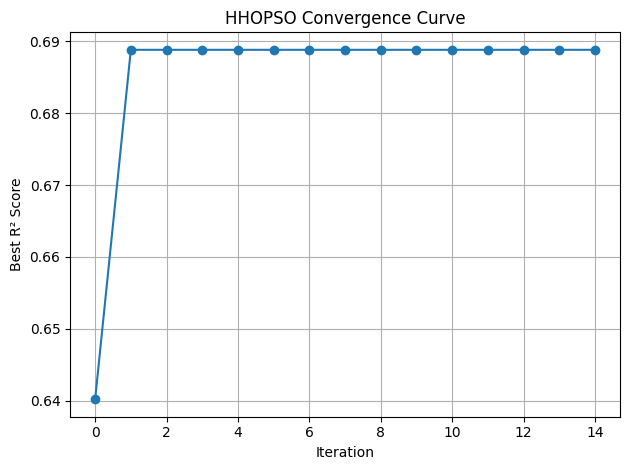

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
from sklearn.exceptions import ConvergenceWarning
from hhopso import HHOPSO  # Ensure your HHOPSO module is accessible

# === Suppress convergence warnings ===
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# === Load dataset ===
csv_file = 'processed_heat_stress_data_UNSCALED.csv'
input_cols = list(range(2, 5)) + list(range(6, 12))
target_col = 12
data = pd.read_csv(csv_file).dropna()
X = data.iloc[:, input_cols].values
y = data.iloc[:, target_col].values

# === Train-test split (70% train, 30% test) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# === Normalize using only training data ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Objective function ===
def nn_objective(x):
    l1 = int(np.clip(np.round(x[0]), 5, 100))
    l2 = int(np.clip(np.round(x[1]), 5, 100))
    l3 = int(np.clip(np.round(x[2]), 5, 100))

    try:
        print(f"Evaluating: ({l1}, {l2}, {l3})")
        model = MLPRegressor(
            hidden_layer_sizes=(l1, l2, l3),
            activation='tanh',
            solver='lbfgs',
            max_iter=1000,
            random_state=42
        )
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)
        print(f"R²: {r2:.5f}")
    except Exception as e:
        r2 = -np.inf
        print(f"Failed: {e}")

    return -r2  # HHOPSO minimizes

# === HHOPSO Settings ===
dim = 3
bounds = np.array([
    [5, 100],  # Layer 1 neurons
    [5, 100],  # Layer 2 neurons
    [5, 100],  # Layer 3 neurons
])
steps = 15
pop_size = 20
w = 0.4
c1 = 2.05
c2 = 2.05
seed = 8
vis = False

# === Start timing ===
start_time = time.time()

# === Run HHOPSO ===
bestsol, bestfit, hist = HHOPSO(
    func=nn_objective,
    dim=dim,
    bounds=bounds,
    steps=steps,
    size=pop_size,
    w=w,
    c1=c1,
    c2=c2,
    seed=seed,
    vis=vis
)

# === Convert convergence history from -R² to R² ===
r2_history = [-f for f in hist]

# === Save convergence curve to CSV ===
df_hist = pd.DataFrame({
    'Iteration': range(1, len(r2_history) + 1),
    'Best_R2': r2_history
})
df_hist.to_csv('convergence_run10.csv', index=False)
print("Convergence history saved to 'convergence_run10.csv'")

# === Retrain best model and compute metrics ===
best_l1 = int(np.round(bestsol[0]))
best_l2 = int(np.round(bestsol[1]))
best_l3 = int(np.round(bestsol[2]))

final_model = MLPRegressor(
    hidden_layer_sizes=(best_l1, best_l2, best_l3),
    activation='tanh',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
final_model.fit(X_train_scaled, y_train)
final_preds = final_model.predict(X_test_scaled)

final_r2 = r2_score(y_test, final_preds)
final_mse = mean_squared_error(y_test, final_preds)
final_mae = mean_absolute_error(y_test, final_preds)

# === End timing ===
end_time = time.time()
elapsed_time = end_time - start_time

# === Output ===
print("\nBest hidden layer sizes found:")
print(f"  Layer 1 size: {best_l1}")
print(f"  Layer 2 size: {best_l2}")
print(f"  Layer 3 size: {best_l3}")
print(f"\nPerformance on Test Set:")
print(f"  R² Score: {final_r2:.5f}")
print(f"  Mean Squared Error (MSE): {final_mse:.5f}")
print(f"  Mean Absolute Error (MAE): {final_mae:.5f}")
print(f"\nTotal Runtime: {elapsed_time:.2f} seconds")

# === Plot Convergence Curve ===
plt.plot(r2_history, marker='o', linestyle='-')
plt.title("HHOPSO Convergence Curve")
plt.xlabel("Iteration")
plt.ylabel("Best R² Score")
plt.grid(True)
plt.tight_layout()
plt.show()
